In [15]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential,load_model
import cupy as cp
from keras.layers import LSTM
from  tensorflow.keras.layers import LSTM,Dense,Activation,Dropout
from  tensorflow.keras.callbacks import History,Callback,EarlyStopping
import os
import tensorflow as tf
import datetime
import h5py

In [16]:
f = h5py.File('D:/library/Github/Innovative-practice/library/csv/第三学期/trainX.h5', 'r')
trainX = f['data']
trainX  = cp.array(trainX)
f.close()
f = h5py.File('D:/library/Github/Innovative-practice/library/csv/第三学期/trainY.h5', 'r')
trainY = f['data']
trainY  = cp.array(trainY)
f.close()
f = h5py.File('D:/library/Github/Innovative-practice/library/csv/第三学期/testX.h5', 'r')
testX = f['data']
testX  = cp.array(testX)
f.close()
f = h5py.File('D:/library/Github/Innovative-practice/library/csv/第三学期/testY.h5', 'r')
testY = f['data']
testY  = cp.array(testY)
f.close()
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(101700, 24, 3)
(101700, 3)
(42300, 24, 3)
(42300, 3)


In [17]:
#选择要测试kpi sms=0 call=1 internet=2
kpi=2
if kpi==0:
    kpi_name='sms'
elif kpi==1:
    kpi_name='call'
else:
    kpi_name='internet'

In [18]:
#查找每个kpi最大值
trainmax=[int(cp.max(trainX[:,:,0])),int(cp.max(trainX[:,:,1])),int(cp.max(trainX[:,:,2]))]
testmax=[int(cp.max(testX[:,:,0])),int(cp.max(testX[:,:,1])),int(cp.max(testX[:,:,2]))]
print(trainmax)
print(testmax)


[753, 643, 6038]
[947, 552, 4529]


In [19]:
#归一化
for i in range(3):
    trainX[:,:,i] = trainX[:,:,i]/trainmax[i]
    testX[:,:,i] = testX[:,:,i]/testmax[i]
    trainY[:,i] = trainY[:,i]/trainmax[i]

In [20]:

trainY = cp.reshape(trainY[:,kpi], (trainY.shape[0], 1))
testY = cp.reshape(testY[:,kpi], (testY.shape[0], 1))
print(trainY.shape)
print(testY.shape)

(101700, 1)
(42300, 1)


In [21]:
model = Sequential()
model.add(LSTM(60,input_shape=(trainX.shape[1],trainX.shape[2]),
                   return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(60,return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(trainY.shape[1]))
model.add(Activation("relu"))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 24, 60)            15360     
                                                                 
 dropout_2 (Dropout)         (None, 24, 60)            0         
                                                                 
 lstm_3 (LSTM)               (None, 60)                29040     
                                                                 
 dropout_3 (Dropout)         (None, 60)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 61        
                                                                 
 activation_1 (Activation)   (None, 1)                 0         
                                                                 
Total params: 44,461
Trainable params: 44,461
Non-trai

In [22]:


cbs = [History(), EarlyStopping(monitor='val_loss',
                                patience=10,
                                min_delta=0.00001,
                                verbose=0)]
model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")+kpi_name
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
history=model.fit(trainX.get(),
        trainY.get(),
        batch_size=64,
        epochs=200,
        validation_split=0.2,
        callbacks=[cbs,tensorboard_callback],
        verbose=True)
model.save(os.path.join(f"D:\library\Github\Innovative-practice\第三学期\DATA\lstm",f"Test_{kpi_name}" + ".h5"))

Epoch 1/200
1272/1272 [==============================] - 14s 9ms/step - loss: 6.4517e-04 - accuracy: 0.0000e+00 - val_loss: 4.5257e-04 - val_accuracy: 0.0000e+00
Epoch 2/200
1272/1272 [==============================] - 11s 9ms/step - loss: 3.5830e-04 - accuracy: 0.0000e+00 - val_loss: 2.9877e-04 - val_accuracy: 0.0000e+00
Epoch 3/200
1272/1272 [==============================] - 10s 8ms/step - loss: 3.1293e-04 - accuracy: 0.0000e+00 - val_loss: 3.4967e-04 - val_accuracy: 0.0000e+00
Epoch 4/200
1272/1272 [==============================] - 12s 9ms/step - loss: 2.9800e-04 - accuracy: 0.0000e+00 - val_loss: 4.2097e-04 - val_accuracy: 0.0000e+00
Epoch 5/200
1272/1272 [==============================] - 11s 8ms/step - loss: 2.8546e-04 - accuracy: 0.0000e+00 - val_loss: 2.7988e-04 - val_accuracy: 0.0000e+00
Epoch 6/200
1272/1272 [==============================] - 11s 9ms/step - loss: 2.7823e-04 - accuracy: 0.0000e+00 - val_loss: 4.0665e-04 - val_accuracy: 0.0000e+00
Epoch 7/200
1272/1272 [=====

In [23]:
%tensorboard --logdir D:\library\Github\Innovative-practice\第三学期\lstm\logs\fit

UsageError: Line magic function `%tensorboard` not found.


In [24]:
#预测
model = load_model(os.path.join(f"D:\library\Github\Innovative-practice\第三学期\DATA\lstm",f"Test_{kpi_name}" + ".h5"))
trainPredict = model.predict(trainX.get())
testPredict = model.predict(testX[:].get())

print(trainPredict.shape)
print(testPredict.shape)



1322/1322 [==============================] - 4s 3ms/step
(101700, 1)
(42300, 1)


In [25]:
testPredict = testPredict
testY = testY.get()

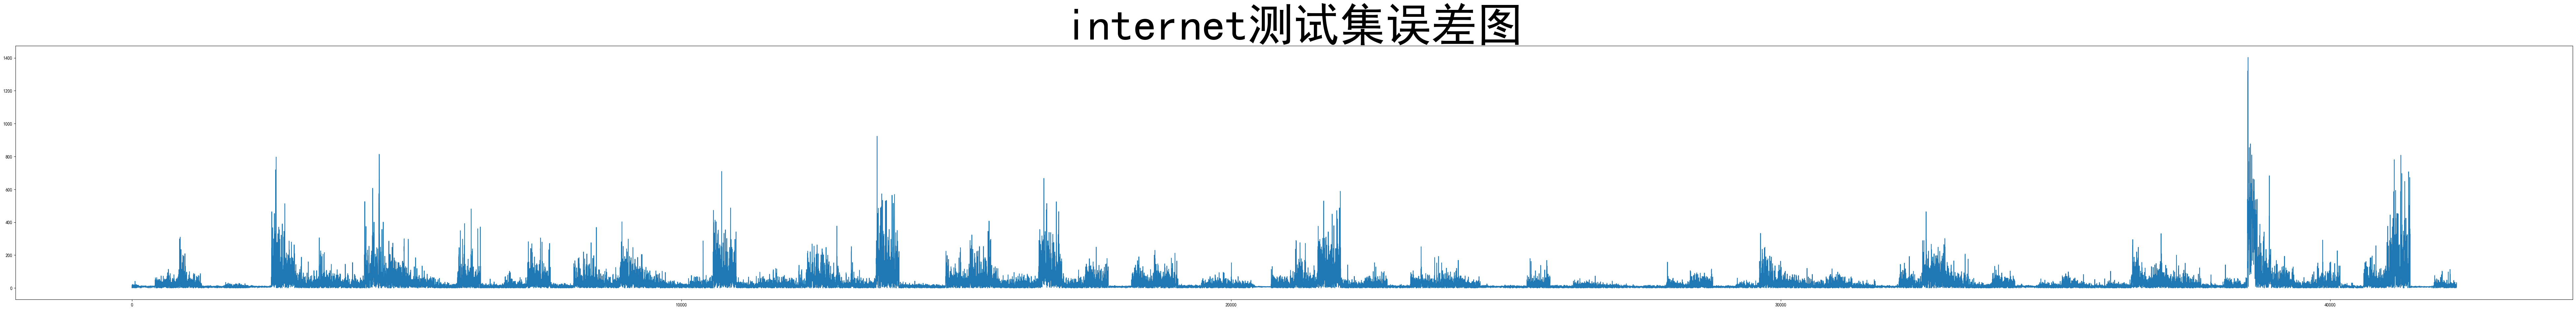

In [26]:
#testY和testPredict的差值的绝对值
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

plt.figure( figsize=(100,10) )
plt.plot(abs(testY[:]-testPredict*testmax[kpi]))
plt.title(f"{kpi_name}测试集误差图",fontsize=100)
plt.savefig(f'D:\library\Github\Innovative-practice\第三学期\DATA\pic\lstm\{kpi_name}测试集误差图.png')
plt.show()

In [27]:
import matplotlib.pyplot as plt
# 解决中文显示问题
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
for i in range(50):
    plt.figure( figsize=(100,10) )
    plt.plot(testY[i*423:(i+1)*423])
    plt.plot(testPredict[i*423:(i+1)*423]*testmax[kpi])
    plt.title(f"{kpi_name}测试集预测图{i}",fontsize=100)
    plt.legend(['testY',"testYPredict"],fontsize=50)
    plt.savefig(f'D:\library\Github\Innovative-practice\第三学期\DATA\pic\lstm\pred\{kpi_name}\{kpi_name}测试集预测图{i}.png')
    #不显示图像
    plt.close()
   


In [28]:
from  sklearn import  metrics
import numpy as np

def GetRMSE(y_hat,y_test):
    sum = np.sqrt(metrics.mean_squared_error(y_test, y_hat))
    return  sum

def GetMAE(y_hat,y_test):
    sum = metrics.mean_absolute_error(y_test, y_hat)
    return  sum

def GetMAPE_Order(y_hat,y_test):
    #删除test_y 为0元素
    zero_index = np.where(y_test == 0)
    y_hat = np.delete(y_hat,zero_index[0])
    y_test = np.delete(y_test,zero_index[0])
    sum = np.mean(np.abs((y_hat - y_test) / y_test)) * 100
    return sum
#计算R2
def GetR2(y_hat,y_test):
    sum = metrics.r2_score(y_test, y_hat)
    return sum
print(type(testY))
rmse=[]
mae=[]
mape_order=[]
r2=[]
testPredict1=testPredict*testmax[kpi]
for i in range(100):
    rmse.append(GetRMSE(testPredict1[i*423:(i+1)*423],testY[i*423:(i+1)*423]))
    mae.append(GetMAE(testPredict1[i*423:(i+1)*423],testY[i*423:(i+1)*423]))
    mape_order.append(GetMAPE_Order(testPredict1[i*423:(i+1)*423],testY[i*423:(i+1)*423]))
    r2.append(GetR2(testPredict1[i*423:(i+1)*423],testY[i*423:(i+1)*423]))

print("RMSE为", np.mean(rmse))
print("MAE为", np.mean(mae))
print("MAPE为", np.mean(mape_order))
print("R2为", np.mean(r2))


<class 'numpy.ndarray'>
RMSE为 42.814139882059216
MAE为 31.597502818734096
MAPE为 61.956592843578754
R2为 0.7056113924271473
